In [1]:
import numpy as np

from utils import *
from generate_data import * 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from network import *

from plot_data import *
from data_loading import *

import json

from gaussian_predictor_levelsets import *
from gaussian_predictor_likelihood import *
from gaussian_trainer import *
from covariances import *
from MVCS import *
from OT_predictor import *

seed_everything(42)

In [ ]:
seed_everything(42)

class RadiusTransformation2:
    def __init__(self, d, beta=None):
        if beta is None:
            beta = np.random.randn(d)
        self.beta = beta

    def get(self, x):
        return ((( np.linalg.norm(x)) / 2.0 + (np.dot(self.beta, x))**2 / 10) / 2 ) / .5 + 0.15
        return ( np.linalg.norm(x)) / 2.0 + np.exp(np.dot(self.beta, x))

d = 2
hidden_dim = 5
hidden_dim_matrix = 100
k = 2

tab_coverage = []
tab_warm_start_covariance_coverage = []
tab_warm_start_local_covariance_coverage = []
tab_hyper_rectangle_coverage = []

pert = "exponential"

n_train = 20_000
n_test = 1_000
n_calibration = 1_000
n_stop = 1_000
n_anchors = 10



config_name = "exp_t"

config_path = "../parameters/" + config_name + ".json"

with open(config_path, 'r') as file : 
    parameters = json.load(file)



hidden_dim = parameters["hidden_dim"]
hidden_dim_matrix = parameters["hidden_dim_matrix"]
n_hidden_layers = parameters["n_hidden_layers"]
n_hidden_layers_matrix = parameters["n_hidden_layers_matrix"]


num_epochs = parameters["num_epochs"]

lr_center = parameters["lr_center"]    
lr_matrix = parameters["lr_matrix"]

batch_size = parameters["batch_size"]

use_lr_scheduler = parameters["use_lr_scheduler"]
keep_best = parameters["keep_best"] 

idx_knowned = np.array(parameters["idx_knowned"])

dtype = torch.float32 if parameters["dtype"] == "float32" else torch.float64

alpha = parameters["alpha"]
print(alpha)

class NonLinearFunction2:
    def __init__(self, d, k, beta=None):
        if beta is None:
            beta = np.random.randn(d, k)
        self.beta = beta
        self.proj  = np.zeros((d, k))
        self.proj[0, 0] = 1.0
        self.proj[1, 1] = 1.0

    def get(self, x):
        nonlinear_term = np.sin(np.dot(x, self.beta)) + 0.5 * np.tanh(np.dot(x**2, self.beta)) + np.dot(x, self.proj)
        return nonlinear_term * 2

f_star = NonLinearFunction2(d, k)
radius = RadiusTransformation2(d)
local_perturbation = LocalPerturbation(d, k, n_anchors=n_anchors, radius_transformation=radius)
data_generator = DataGenerator(d, k, pert, f_star=f_star, local_perturbation=local_perturbation, covariance_matrix=np.array([[1.0, 0.5],[0.5, 1.0]]), bias = False, seed = 42)

x_train, y_train = data_generator.generate(n_train)
x_stop, y_stop = data_generator.generate(n_stop)
x_calibration, y_calibration = data_generator.generate(n_calibration)
x_test, y_test = data_generator.generate(n_test)


x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_stop_tensor = torch.tensor(x_stop, dtype=torch.float32)
y_stop_tensor = torch.tensor(y_stop, dtype=torch.float32)
x_calibration_tensor = torch.tensor(x_calibration, dtype=torch.float32)
y_calibration_tensor = torch.tensor(y_calibration, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



0.1


In [5]:
seed_everything(42)

center_model = Network(d, k, hidden_dim=hidden_dim, n_hidden_layers=n_hidden_layers).to(dtype)
matrix_model = MatrixPredictor(d, k, k, hidden_dim=hidden_dim_matrix).to(dtype)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size, shuffle=True)
calibrationloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_calibration_tensor, y_calibration_tensor), batch_size= batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor), batch_size= batch_size, shuffle=True)

gaussian_predictor = GaussianTrainer(center_model, matrix_model, dtype=dtype)

center_model.fit_and_plot(trainloader, 
                            stoploader, 
                            num_epochs, 
                            keep_best = True, 
                            lr = lr_center, 
                            verbose=False)

gaussian_predictor.fit(trainloader, 
                        stoploader, 
                        num_epochs = num_epochs,
                        lr_center_models = 0.0,
                        lr_matrix_models = lr_matrix,
                        use_lr_scheduler = use_lr_scheduler,
                        verbose = 1,
                        stop_on_best = keep_best
                        )

Epoch 0: Loss = 2.3140876293182373 - Stop Loss = 2.1960084438323975 - Best Stop Loss = 2.1960084438323975
Epoch 100: Loss = 0.4170871376991272 - Stop Loss = 0.3723328113555908 - Best Stop Loss = 0.36761674284935
Epoch 200: Loss = 0.4151488244533539 - Stop Loss = 0.38336679339408875 - Best Stop Loss = 0.36761674284935
Epoch 300: Loss = 0.4152384102344513 - Stop Loss = 0.37472447752952576 - Best Stop Loss = 0.36597809195518494
Epoch 400: Loss = 0.41477882862091064 - Stop Loss = 0.3711482584476471 - Best Stop Loss = 0.3634034991264343
Epoch 500: Loss = 0.4078251123428345 - Stop Loss = 0.3693297207355499 - Best Stop Loss = 0.3634034991264343
Epoch 600: Loss = 0.4083889424800873 - Stop Loss = 0.3640594184398651 - Best Stop Loss = 0.36164742708206177
Epoch 700: Loss = 0.402457058429718 - Stop Loss = 0.36731916666030884 - Best Stop Loss = 0.36164742708206177
Epoch 800: Loss = 0.40224456787109375 - Stop Loss = 0.36693769693374634 - Best Stop Loss = 0.36164742708206177
Epoch 900: Loss = 0.40110

In [6]:
mvcs_matrix_model = MatrixPredictor(d, k, k, hidden_dim=hidden_dim_matrix).to(dtype)
MVCS_predictor = MVCSPredictor(center_model, mvcs_matrix_model, dtype=dtype)

MVCS_predictor.fit(trainloader, 
                stoploader, 
                alpha,
                num_epochs = num_epochs,             # The total number of epochs
                num_epochs_mat_only = num_epochs,    # The first 100 epochs are used to train the matrix model only
                lr_model = 0.0,            # The learning rate for the center model
                lr_matrix_model = lr_matrix,      # The learning rate for the matrix model
                verbose = 1,                  # The verbosity level (0 : No verbose; 1: Print the loss 10 times or 2: Print the loss at each epoch)
                )

Epoch 0: Loss = nan - Stop Loss = nan - Best Stop Loss = inf
Epoch 100: Loss = 2.3040480613708496 - Stop Loss = 2.2899112701416016 - Best Stop Loss = 2.2035069465637207
Epoch 200: Loss = 2.2387804985046387 - Stop Loss = 2.2758593559265137 - Best Stop Loss = 2.14479398727417
Epoch 300: Loss = 2.2375054359436035 - Stop Loss = 2.263796329498291 - Best Stop Loss = 2.14479398727417
Epoch 400: Loss = 2.2255029678344727 - Stop Loss = 2.264470100402832 - Best Stop Loss = 2.14479398727417
Epoch 500: Loss = 2.2165818214416504 - Stop Loss = 2.230402946472168 - Best Stop Loss = 2.14479398727417
Epoch 600: Loss = 2.224748134613037 - Stop Loss = 2.237189292907715 - Best Stop Loss = 2.14479398727417
Epoch 700: Loss = 2.210841178894043 - Stop Loss = 2.2362513542175293 - Best Stop Loss = 2.14479398727417
Epoch 800: Loss = 2.207491397857666 - Stop Loss = 2.221432685852051 - Best Stop Loss = 2.14479398727417
Epoch 900: Loss = 2.2011399269104004 - Stop Loss = 2.196120262145996 - Best Stop Loss = 2.1447939

In [7]:
center_model = gaussian_predictor.center_model
matrix_model = gaussian_predictor.matrix_model

gaussian_level_sets = GaussianPredictorLevelsets(center_model, matrix_model, dtype=dtype)
gaussian_likelihood = GaussianPredictorLikelihood(center_model, matrix_model, dtype=dtype)
ot_predictor = OTPredictor(center_model, int(len(x_calibration) * 0.1) )
one_covariance_predictor = CovariancePredictor(gaussian_predictor.center_model)
one_covariance_predictor.fit_cov(trainloader, x_train_tensor, y_train_tensor)

In [8]:
gaussian_level_sets.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)
gaussian_likelihood.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)
one_covariance_predictor.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)
ot_predictor.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)
MVCS_predictor.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)

In [9]:
idx_knowned = np.array([0])

gaussian_level_sets.conformalize_with_knowned_idx(x_calibration=x_calibration_tensor, 
                                            y_calibration=y_calibration_tensor, 
                                            alpha = alpha, 
                                            idx_knowned=idx_knowned)

gaussian_likelihood.conformalize_with_knowned_idx(x_calibration=x_calibration_tensor, 
                                            y_calibration=y_calibration_tensor, 
                                            alpha = alpha, 
                                            idx_knowned=idx_knowned)

ot_predictor.conformalize_with_knowned_idx(idx_knowned=idx_knowned)
MVCS_predictor.conformalize_with_knowned_idx(idx_knowned)

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/3885315616.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/3885315616.py:66: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/3885315616.py:67: UserWarning: *c* argument looks like a single numeric RGB or RGBA se

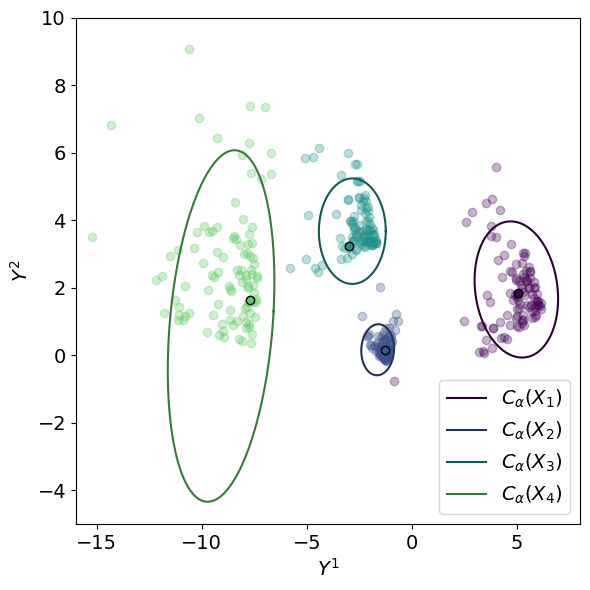

In [ ]:
tab_seed = [0, 2, 56, 79]
q_val = 2.0
dtype = torch.float32

coverage_emp = []

idx_unknown = np.setdiff1d(np.arange(k), idx_knowned) 

fig, ax = plt.subplots(figsize=(6, 6))


color_map = plt.cm.get_cmap('viridis', 5)
colors = color_map(np.linspace(0, 1, 5))
darker_colors = colors.copy()
from matplotlib.colors import ListedColormap
darker_viridis = ListedColormap(darker_colors)
darker_colors[:, :3] *= 0.6

for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        x_specific, y_specific = data_generator.generate_specific_x(100)

        if seed == 14:
                y_specific[0] = np.array([9.0, 0.0])

        x_specific_tensor = torch.tensor(x_specific, dtype=dtype)
        y_specific_tensor = torch.tensor(y_specific, dtype=dtype)

        centers = gaussian_level_sets.get_centers(x_specific_tensor)
        centers_np = centers.detach().numpy()
        Lambdas_specific = gaussian_level_sets.get_Lambdas(x_specific_tensor)
        Lambdas_specific_np = Lambdas_specific.detach().numpy()

        radius = gaussian_level_sets.nu_conformal.item()

        ax = add_ellipse(ax,  centers_np[0], Lambdas_specific_np[0], q_val, radius, color = darker_viridis(i),  label=fr'$C_\alpha(X_{{{i+1}}})$')
          
        coverage_emp.append(gaussian_level_sets.get_coverage(x_specific_tensor, y_specific_tensor))
          
        ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
        ax.scatter(y_specific[0, 0], y_specific[0, 1], label=None, c = color_map(i), edgecolors='black', zorder=10)

        ax.set_xlabel(r'$Y^1$', fontsize=14)
        ax.set_ylabel(r'$Y^2$', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        ax.legend(fontsize=14, loc='lower right')

        ax.set_xlim(-16, 8)
        ax.set_ylim(-5, 10)


plt.tight_layout()

plt.savefig(f"../figs/{pert}_level_sets_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.png", dpi = 300, bbox_inches='tight')
plt.savefig(f"../figs/{pert}_level_sets_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.pdf", dpi = 300, bbox_inches='tight')

plt.show()

plt.close()

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/3504703039.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/3504703039.py:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/3504703039.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA se

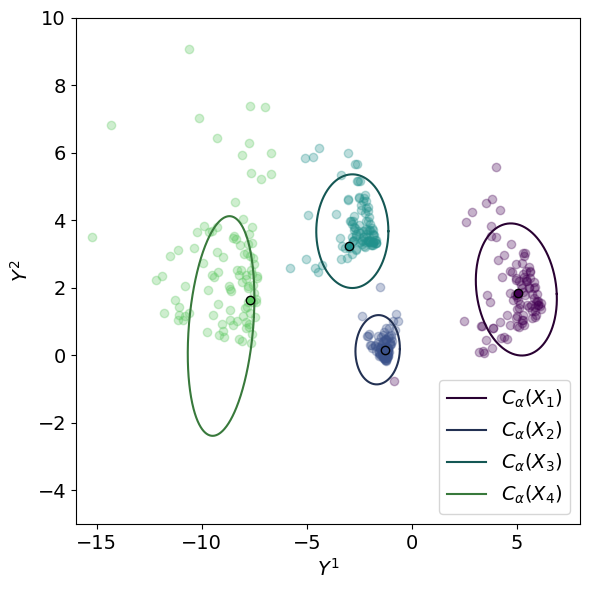

In [13]:
tab_seed = [6, 15, 14, 26]
tab_seed = [0, 2, 56, 79]
q_val = 2.0
dtype = torch.float32

idx_unknown = np.setdiff1d(np.arange(k), idx_knowned) 
coverage_emp = []
fig, ax = plt.subplots(figsize=(6, 6))

color_map = plt.cm.get_cmap('viridis', 5)
colors = color_map(np.linspace(0, 1, 5))
darker_colors = colors.copy()
from matplotlib.colors import ListedColormap
darker_viridis = ListedColormap(darker_colors)
darker_colors[:, :3] *= 0.6

for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        x_specific, y_specific = data_generator.generate_specific_x(100)

        if seed == 14:
                y_specific[0] = np.array([9.0, 0.0])

        x_specific_tensor = torch.tensor(x_specific, dtype=dtype)
        y_specific_tensor = torch.tensor(y_specific, dtype=dtype)

        centers = gaussian_likelihood.get_centers(x_specific_tensor)
        centers_np = centers.detach().numpy()
        Lambdas_specific = gaussian_likelihood.get_Lambdas(x_specific_tensor)
        Lambdas_specific_np = Lambdas_specific.detach().numpy()

        radius = gaussian_likelihood.get_radius(x_specific_tensor[0]).detach().numpy()

        ax = add_ellipse(ax,  centers_np[0], Lambdas_specific_np[0], q_val, radius, color = darker_viridis(i), label=fr'$C_\alpha(X_{{{i+1}}})$')
          
        coverage_emp.append(gaussian_likelihood.get_coverage(x_specific_tensor, y_specific_tensor))

        # y_values = []
        # for j in range(1):
        #         t = y_specific_tensor[j, 0]                
        #         for y in np.linspace(-10, 10, 10_000):  # Plage de valeurs pour y
        #                 t_y = torch.tensor([t, y], dtype = dtype).unsqueeze(0)                         
                        
        #                 y_r = t_y[:, idx_knowned]
        #                 y_s = t_y[:, idx_unknown]

        #                 inside = gaussian_likelihood.get_coverage_condition_on_idx(x_specific_tensor[[0]] ,t_y)

        #                 if inside:
        #                         y_values.append(y)

        #                 # new_centers, new_Lambdas = get_new_centers_Lambdas_with_knowned_idx(y_r, centers[0:1, :], Lambdas_specific[0:1,:,:], idx_knowned)
                                        
        #                 # score = get_ellipse_scores(y_s, new_centers, new_Lambdas)

        #                 # if score <= gaussian_likelihood.nu_conformal_conditional.item():
        #                         # y_values.append(y)
                            
        #         ax.plot([t, t], [min(y_values), max(y_values)], label=None, color=color_map(i))
        #         # ax.plot([t, t], [min(y_values), max(y_values)], label=None, color="red")        
        
        ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
        ax.scatter(y_specific[0, 0], y_specific[0, 1], label=None, c = color_map(i), edgecolors='black', zorder=10)

        # points = gaussian_predictor.get_estimation_conditional_points_to_keep(x_specific_tensor[0], y_specific_tensor[0][idx_knowned], n_samples = 10000)
        # ax.scatter(*points.T, label=None, c = tab_clair_colors[i], edgecolors='none', zorder=-1)

        ax.set_xlabel(r'$Y^1$', fontsize=14)
        ax.set_ylabel(r'$Y^2$', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        ax.legend(fontsize=14, loc='lower right')
        # ax.legend().remove()
        ax.set_xlim(-16, 8)
        ax.set_ylim(-5, 10)


plt.tight_layout()

plt.savefig(f"../figs/{pert}_likelihood_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.png", dpi = 300, bbox_inches='tight')
plt.savefig(f"../figs/{pert}_likelihood_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.pdf", dpi = 300, bbox_inches='tight')

plt.show()

plt.close()

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/3078260139.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/3078260139.py:69: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/3078260139.py:70: UserWarning: *c* argument looks like a single numeric RGB or RGBA se

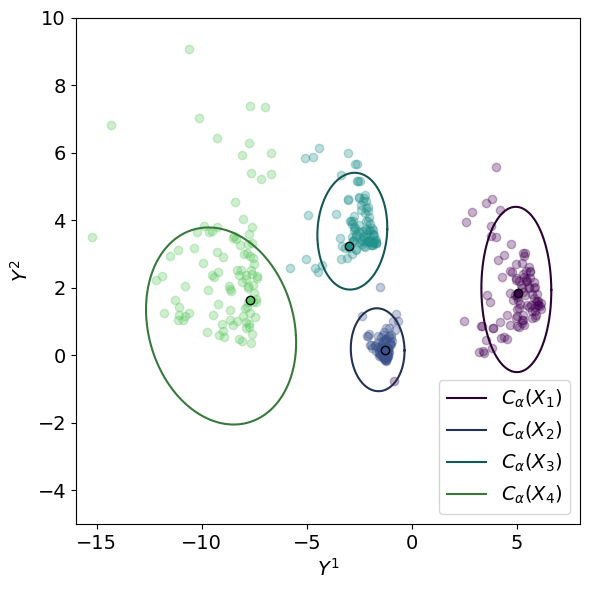

In [14]:
tab_seed = [0, 2, 56, 79]

dtype = torch.float32

idx_unknown = np.setdiff1d(np.arange(k), idx_knowned) 

fig, ax = plt.subplots(figsize=(6, 6))

coverage_emp = []

color_map = plt.cm.get_cmap('viridis', 5)
colors = color_map(np.linspace(0, 1, 5))
darker_colors = colors.copy()
from matplotlib.colors import ListedColormap
darker_viridis = ListedColormap(darker_colors)
darker_colors[:, :3] *= 0.6

for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        x_specific, y_specific = data_generator.generate_specific_x(100)

        if seed == 14:
                y_specific[0] = np.array([9.0, 0.0])

        x_specific_tensor = torch.tensor(x_specific, dtype=dtype)
        y_specific_tensor = torch.tensor(y_specific, dtype=dtype)

        centers = MVCS_predictor.center_model(x_specific_tensor)
        centers_np = centers.detach().numpy()
        Lambdas_specific = MVCS_predictor.get_Lambdas(x_specific_tensor)
        Lambdas_specific_np = Lambdas_specific.detach().numpy()

        q_val = MVCS_predictor.q.item()

        radius = MVCS_predictor.nu_conformal.item()

        coverage_emp.append(MVCS_predictor.get_coverage(x_specific_tensor, y_specific_tensor))

        ax = add_ellipse(ax,  centers_np[0], Lambdas_specific_np[0], q_val, radius, color = darker_viridis(i),  label=fr'$C_\alpha(X_{{{i+1}}})$')
          
        # y_values = []
        # for j in range(1):
        #         t = y_specific_tensor[j, 0]                
        #         for y in np.linspace(-10, 10, 10_000):  # Plage de valeurs pour y
        #                 t_y = torch.tensor([t, y], dtype = dtype).unsqueeze(0)                         
                        
        #                 y_r = t_y[:, idx_knowned]
        #                 y_s = t_y[:, idx_unknown]

        #                 inside = MVCS_predictor.get_coverage(x_specific_tensor[[0]] ,t_y)

        #                 if inside:
        #                         y_values.append(y)

        #                 # new_centers, new_Lambdas = get_new_centers_Lambdas_with_knowned_idx(y_r, centers[0:1, :], Lambdas_specific[0:1,:,:], idx_knowned)
                                        
        #                 # score = get_ellipse_scores(y_s, new_centers, new_Lambdas)

        #                 # if score <= gaussian_likelihood.nu_conformal_conditional.item():
        #                         # y_values.append(y)
                            
        #         try:
        #                 ax.plot([t, t], [min(y_values), max(y_values)], label=None, color=color_map(i))
        #         except:
        #                 print("No values found for this specific x")
        #                 continue
        #         # ax.plot([t, t], [min(y_values), max(y_values)], label=None, color="red")        
        
        ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
        ax.scatter(y_specific[0, 0], y_specific[0, 1], label=None, c = color_map(i), edgecolors='black', zorder=10)

        # points = gaussian_predictor.get_estimation_conditional_points_to_keep(x_specific_tensor[0], y_specific_tensor[0][idx_knowned], n_samples = 10000)
        # ax.scatter(*points.T, label=None, c = tab_clair_colors[i], edgecolors='none', zorder=-1)

        ax.set_xlabel(r'$Y^1$', fontsize=14)
        ax.set_ylabel(r'$Y^2$', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        ax.legend(fontsize=14, loc='lower right')
        # ax.legend().remove()
        ax.set_xlim(-16, 8)
        ax.set_ylim(-5, 10)


plt.tight_layout()

plt.savefig(f"../figs/{pert}_MVCS_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.png", dpi = 300, bbox_inches='tight')
plt.savefig(f"../figs/{pert}_MVCS_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.pdf", dpi = 300, bbox_inches='tight')

plt.show()

plt.close()

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/2634613104.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/2634613104.py:67: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/2634613104.py:68: UserWarning: *c* argument looks like a single numeric RGB or RGBA se

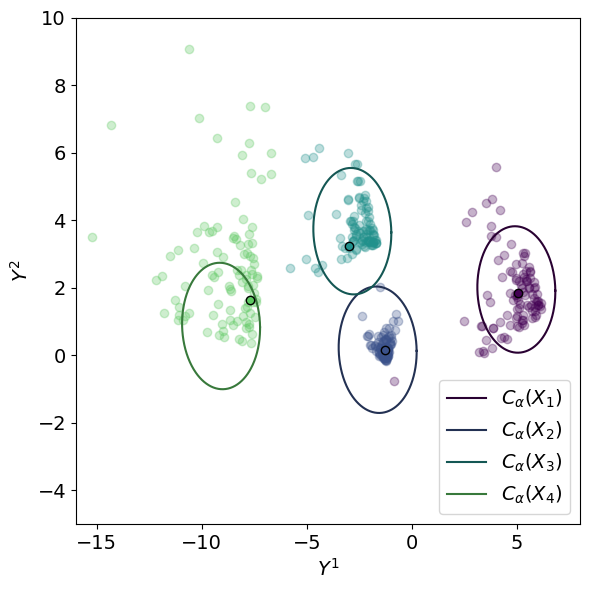

In [15]:
tab_seed = [0, 2, 56, 79]
q_val = 2.0
dtype = torch.float32

idx_unknown = np.setdiff1d(np.arange(k), idx_knowned) 

coverage_emp = []

fig, ax = plt.subplots(figsize=(6, 6))

color_map = plt.cm.get_cmap('viridis', 5)
colors = color_map(np.linspace(0, 1, 5))
darker_colors = colors.copy()
from matplotlib.colors import ListedColormap
darker_viridis = ListedColormap(darker_colors)
darker_colors[:, :3] *= 0.6

for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        x_specific, y_specific = data_generator.generate_specific_x(100)

        if seed == 14:
                y_specific[0] = np.array([9.0, 0.0])

        x_specific_tensor = torch.tensor(x_specific, dtype=dtype)
        y_specific_tensor = torch.tensor(y_specific, dtype=dtype)

        centers = gaussian_likelihood.get_centers(x_specific_tensor)
        centers_np = centers.detach().numpy()
        Lambdas_specific = one_covariance_predictor.get_Lambdas(x_specific_tensor)
        Lambdas_specific_np = Lambdas_specific.detach().numpy()

        radius = one_covariance_predictor.nu_conformal.item()

        ax = add_ellipse(ax,  centers_np[0], Lambdas_specific_np[0], q_val, radius, color = darker_viridis(i),  label=fr'$C_\alpha(X_{{{i+1}}})$')
          
        coverage_emp.append(one_covariance_predictor.get_coverage(x_specific_tensor, y_specific_tensor))

        # y_values = []
        # for j in range(1):
        #         t = y_specific_tensor[j, 0]                
        #         for y in np.linspace(-10, 10, 10_000):  # Plage de valeurs pour y
        #                 t_y = torch.tensor([t, y], dtype = dtype).unsqueeze(0)                         
                        
        #                 y_r = t_y[:, idx_knowned]
        #                 y_s = t_y[:, idx_unknown]

        #                 inside = one_covariance_predictor.get_coverage(x_specific_tensor[[0]] ,t_y)

        #                 if inside:
        #                         y_values.append(y)

        #                 # new_centers, new_Lambdas = get_new_centers_Lambdas_with_knowned_idx(y_r, centers[0:1, :], Lambdas_specific[0:1,:,:], idx_knowned)
                                        
        #                 # score = get_ellipse_scores(y_s, new_centers, new_Lambdas)

        #                 # if score <= gaussian_likelihood.nu_conformal_conditional.item():
        #                         # y_values.append(y)
                            
        #         try :
        #             ax.plot([t, t], [min(y_values), max(y_values)], label=None, color=color_map(i))
        #         except:
        #             print("No values found for this specific x")
        #             continue
        #         # ax.plot([t, t], [min(y_values), max(y_values)], label=None, color="red")        
        
        ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
        ax.scatter(y_specific[0, 0], y_specific[0, 1], label=None, c = color_map(i), edgecolors='black', zorder=10)

        # points = gaussian_predictor.get_estimation_conditional_points_to_keep(x_specific_tensor[0], y_specific_tensor[0][idx_knowned], n_samples = 10000)
        # ax.scatter(*points.T, label=None, c = tab_clair_colors[i], edgecolors='none', zorder=-1)

        ax.set_xlabel(r'$Y^1$', fontsize=14)
        ax.set_ylabel(r'$Y^2$', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        ax.legend(fontsize=14, loc='lower right')
        # ax.legend().remove()
        ax.set_xlim(-16, 8)
        ax.set_ylim(-5, 10)


plt.tight_layout()

plt.savefig(f"../figs/{pert}_one_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.png", dpi = 300, bbox_inches='tight')
plt.savefig(f"../figs/{pert}_one_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.pdf", dpi = 300, bbox_inches='tight')

plt.show()

plt.close()

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/2396231829.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/2396231829.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/2396231829.py:66: UserWarning: *c* argument looks like a single numeric RGB or RGBA seq

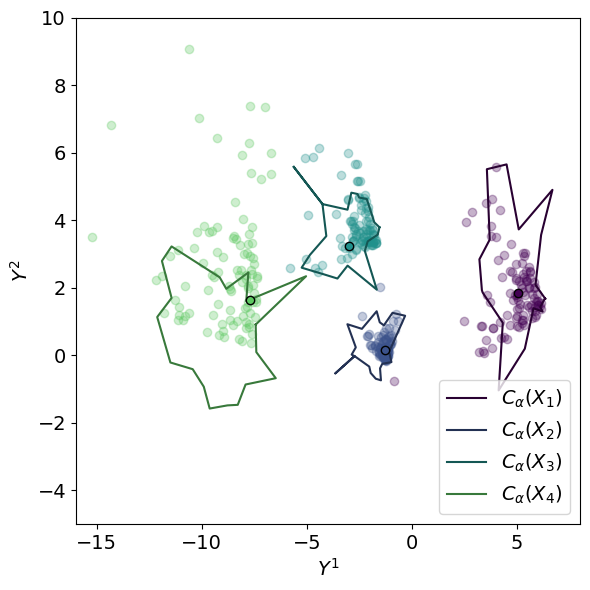

In [16]:
tab_seed = [0, 2, 56, 79]
q_val = 2.0
dtype = torch.float32

idx_unknown = np.setdiff1d(np.arange(k), idx_knowned) 
coverage_emp = []
fig, ax = plt.subplots(figsize=(6, 6))

color_map = plt.cm.get_cmap('viridis', 5)
colors = color_map(np.linspace(0, 1, 5))
darker_colors = colors.copy()
from matplotlib.colors import ListedColormap
darker_viridis = ListedColormap(darker_colors)
darker_colors[:, :3] *= 0.6

for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        x_specific, y_specific = data_generator.generate_specific_x(100)

        if seed == 14:
                y_specific[0] = np.array([9.0, 0.0])

        x_specific_tensor = torch.tensor(x_specific, dtype=dtype)
        y_specific_tensor = torch.tensor(y_specific, dtype=dtype)

        quantile_contours = ot_predictor.get_contour( x_specific_tensor[0])[0]

        ax.plot(quantile_contours[:, 0], quantile_contours[:, 1], color=darker_viridis(i), linestyle='-', label=fr'$C_\alpha(X_{{{i+1}}})$')

        coverage_emp.append(ot_predictor.get_coverage(x_specific_tensor, y_specific_tensor))

        # y_values = []
        # to_plot = []
        # for j in range(1):
        #         t = y_specific_tensor[j, 0]                
        #         for y in np.linspace(-10, 10, 10_000):  # Plage de valeurs pour y
        #                 t_y = torch.tensor([t, y], dtype = dtype).unsqueeze(0)                         
                        
        #                 y_r = t_y[:, idx_knowned]
        #                 y_s = t_y[:, idx_unknown]

        #                 inside = ot_predictor.get_coverage(x_specific_tensor[[0]] , t_y)

        #                 if inside:
        #                         to_plot.append(np.array([t, y]))
        #                         y_values.append(y)

        #                 # new_centers, new_Lambdas = get_new_centers_Lambdas_with_knowned_idx(y_r, centers[0:1, :], Lambdas_specific[0:1,:,:], idx_knowned)
                                        
        #                 # score = get_ellipse_scores(y_s, new_centers, new_Lambdas)

        #                 # if score <= gaussian_likelihood.nu_conformal_conditional.item():
        #                         # y_values.append(y)
                            
        #         try :
        #         #     ax.plot([t, t], [min(y_values), max(y_values)], label=None, color=color_map(i))
        #                 to_plot= np.array(to_plot)
        #                 # ax.scatter(to_plot[:, 0], to_plot[:, 1], color=color_map(i), s = 1, label=fr'$C_\alpha(X_{{{i+1}}}, Y_r)$')
        #                 ax.scatter(to_plot[:, 0], to_plot[:, 1], color=color_map(i), s = 1, label=None)
        #         except:
        #             print("No values found for this specific x")
        #             continue
        #         # ax.plot([t, t], [min(y_values), max(y_values)], label=None, color="red")        
        
        ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
        ax.scatter(y_specific[0, 0], y_specific[0, 1], label=None, c = color_map(i), edgecolors='black', zorder=10)

        # points = gaussian_predictor.get_estimation_conditional_points_to_keep(x_specific_tensor[0], y_specific_tensor[0][idx_knowned], n_samples = 10000)
        # ax.scatter(*points.T, label=None, c = tab_clair_colors[i], edgecolors='none', zorder=-1)

        ax.set_xlabel(r'$Y^1$', fontsize=14)
        ax.set_ylabel(r'$Y^2$', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        ax.legend(fontsize=14, loc='lower right')
        # ax.legend().remove()
        ax.set_xlim(-16, 8)
        ax.set_ylim(-5, 10)


plt.tight_layout()

plt.savefig(f"../figs/{pert}_OT_knn_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.png", dpi = 300, bbox_inches='tight')
plt.savefig(f"../figs/{pert}_OT_knn_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.pdf", dpi = 300, bbox_inches='tight')


plt.show()
plt.close()

In [17]:
ot_predictor = OTPredictor(center_model,-1 )
ot_predictor.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)
ot_predictor.conformalize_with_knowned_idx(idx_knowned=idx_knowned)


/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/706944250.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/706944250.py:66: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82615/706944250.py:67: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequen

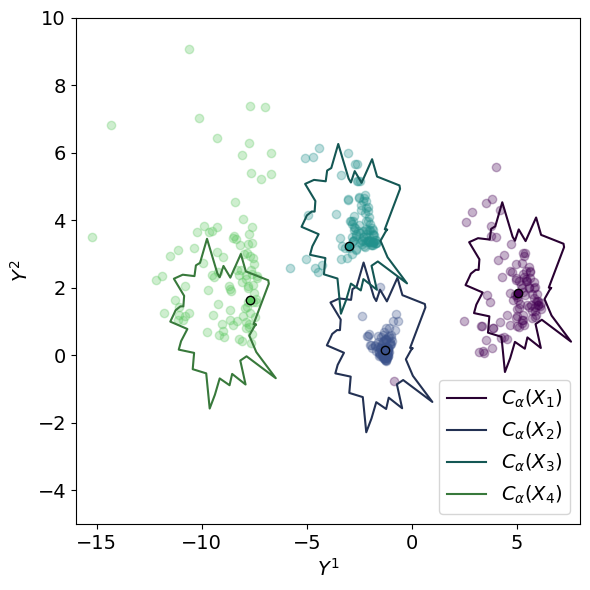

In [18]:
tab_seed = [0, 2, 56, 79]
q_val = 2.0
dtype = torch.float32

idx_unknown = np.setdiff1d(np.arange(k), idx_knowned) 
coverage_emp = []
fig, ax = plt.subplots(figsize=(6, 6))

color_map = plt.cm.get_cmap('viridis', 5)
colors = color_map(np.linspace(0, 1, 5))
darker_colors = colors.copy()
from matplotlib.colors import ListedColormap
darker_viridis = ListedColormap(darker_colors)
darker_colors[:, :3] *= 0.6

for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        x_specific, y_specific = data_generator.generate_specific_x(100)

        if seed == 14:
                y_specific[0] = np.array([9.0, 0.0])

        x_specific_tensor = torch.tensor(x_specific, dtype=dtype)
        y_specific_tensor = torch.tensor(y_specific, dtype=dtype)

        # quantile_contours = get_contour(ot_predictor, x_specific_tensor[0])[0]
        quantile_contours = ot_predictor.get_contour(x_specific_tensor[0])[0]

        ax.plot(quantile_contours[:, 0], quantile_contours[:, 1], color=darker_viridis(i), linestyle='-', label=fr'$C_\alpha(X_{{{i+1}}})$')

        coverage_emp.append(ot_predictor.get_coverage(x_specific_tensor, y_specific_tensor))

        # y_values = []
        # to_plot = []
        # for j in range(1):
        #         t = y_specific_tensor[j, 0]                
        #         for y in np.linspace(-10, 10, 10_000):  # Plage de valeurs pour y
        #                 t_y = torch.tensor([t, y], dtype = dtype).unsqueeze(0)                         
                        
        #                 y_r = t_y[:, idx_knowned]
        #                 y_s = t_y[:, idx_unknown]

        #                 inside = ot_predictor.get_coverage(x_specific_tensor[[0]] , t_y)

        #                 if inside:
        #                         to_plot.append(np.array([t, y]))
        #                         y_values.append(y)

        #                 # new_centers, new_Lambdas = get_new_centers_Lambdas_with_knowned_idx(y_r, centers[0:1, :], Lambdas_specific[0:1,:,:], idx_knowned)
                                        
        #                 # score = get_ellipse_scores(y_s, new_centers, new_Lambdas)

        #                 # if score <= gaussian_likelihood.nu_conformal_conditional.item():
        #                         # y_values.append(y)
                            
        #         try :
        #         #     ax.plot([t, t], [min(y_values), max(y_values)], label=None, color=color_map(i))
        #                 to_plot= np.array(to_plot)
        #                 # ax.scatter(to_plot[:, 0], to_plot[:, 1], color=color_map(i), s = 1, label=fr'$C_\alpha(X_{{{i+1}}}, Y_r)$')
        #                 ax.scatter(to_plot[:, 0], to_plot[:, 1], color=color_map(i), s = 1, label=None)
        #         except:
        #             print("No values found for this specific x")
        #             continue
        #         # ax.plot([t, t], [min(y_values), max(y_values)], label=None, color="red")        
        
        ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
        ax.scatter(y_specific[0, 0], y_specific[0, 1], label=None, c = color_map(i), edgecolors='black', zorder=10)

        # points = gaussian_predictor.get_estimation_conditional_points_to_keep(x_specific_tensor[0], y_specific_tensor[0][idx_knowned], n_samples = 10000)
        # ax.scatter(*points.T, label=None, c = tab_clair_colors[i], edgecolors='none', zorder=-1)

        ax.set_xlabel(r'$Y^1$', fontsize=14)
        ax.set_ylabel(r'$Y^2$', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        ax.legend(fontsize=14, loc='lower right')
        # ax.legend().remove()
        ax.set_xlim(-16, 8)
        ax.set_ylim(-5, 10)


plt.tight_layout()

plt.savefig(f"../figs/{pert}_OT_no_knn_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.png", dpi = 300, bbox_inches='tight')
plt.savefig(f"../figs/{pert}_OT_no_knn_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.pdf", dpi = 300, bbox_inches='tight')


plt.show()
plt.close()